# CSE416 Xiyah, Joanna, Kelly


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Download and save the dataset
import requests
import os

def save_file(url, file_name):
    r = requests.get(url)
    with open(file_name, 'wb') as f:
      f.write(r.content)

if not os.path.exists("./edx_train.csv"):
    save_file('https://courses.cs.washington.edu/courses/cse416/21sp/homework/hw6/edx_train.csv', 
          'edx_train.csv')
if not os.path.exists("./edx_test.csv"):
    save_file('https://courses.cs.washington.edu/courses/cse416/21sp/homework/hw6/edx_test.csv', 
          'edx_test.csv')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset


In [4]:
# encoding data
import pandas as pd
train = pd.read_csv("./edx_train.csv", na_values=" ")
print(train.shape)
train.head(5)


(8758, 18)


,course_id,userid_DI,registered,viewed,explored,certified,final_cc_cname_DI,LoE_DI,YoB,gender,grade,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts
0,HarvardX/CS50x/2012,MHxPC130545492,1,1,1,1,United States,Master's,1984.0,m,1.00,3/10/13,7/29/13,1161.0,50.0,NaN,12.0,0
1,HarvardX/ER22x/2013_Spring,MHxPC130536944,1,1,1,1,United Kingdom,Master's,1985.0,f,0.85,3/13/13,8/1/13,1360.0,10.0,NaN,29.0,0
2,HarvardX/CS50x/2012,MHxPC130442298,1,1,1,1,India,NaN,NaN,NaN,1.00,8/2/12,7/25/13,77.0,18.0,NaN,7.0,0
3,HarvardX/ER22x/2013_Spring,MHxPC130273564,1,1,1,1,United Kingdom,Bachelor's,1982.0,m,0.85,1/23/13,8/13/13,1425.0,29.0,NaN,34.0,0
4,HarvardX/CS50x/2012,MHxPC130247761,1,1,0,0,United States,Secondary,1989.0,m,0.00,3/5/13,3/5/13,6.0,1.0,NaN,1.0,0


In [5]:
test = pd.read_csv("./edx_test.csv", na_values=" ")
print(test.shape)
test.head(5)

(2920, 17)


,course_id,userid_DI,registered,viewed,explored,final_cc_cname_DI,LoE_DI,YoB,gender,grade,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts
0,HarvardX/CS50x/2012,MHxPC130476531,1,1,1,United Kingdom,Secondary,1971.0,m,1.00,10/30/12,6/27/13,132.0,34.0,NaN,12.0,0
1,HarvardX/CB22x/2013_Spring,MHxPC130559898,1,0,0,Other South Asia,Bachelor's,1984.0,m,NaN,2/6/13,11/17/13,NaN,NaN,NaN,NaN,0
2,HarvardX/PH207x/2012_Fall,MHxPC130552712,1,1,1,Egypt,Bachelor's,1985.0,f,0.81,10/20/12,1/18/13,2650.0,32.0,96.0,15.0,0
3,HarvardX/PH278x/2013_Spring,MHxPC130394971,1,1,1,Nigeria,Secondary,1988.0,m,0.87,12/27/12,8/22/13,999.0,17.0,13.0,8.0,0
4,HarvardX/ER22x/2013_Spring,MHxPC130191077,1,1,1,Other Middle East/Central Asia,NaN,NaN,NaN,0.90,5/31/13,9/7/13,2130.0,24.0,NaN,29.0,0


In [6]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8758 entries, 0 to 8757
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   course_id          8758 non-null   object 
 1   userid_DI          8758 non-null   object 
 2   registered         8758 non-null   int64  
 3   viewed             8758 non-null   int64  
 4   explored           8758 non-null   int64  
 5   certified          8758 non-null   int64  
 6   final_cc_cname_DI  8758 non-null   object 
 7   LoE_DI             7792 non-null   object 
 8   YoB                7844 non-null   float64
 9   gender             7983 non-null   object 
 10  grade              8351 non-null   float64
 11  start_time_DI      8758 non-null   object 
 12  last_event_DI      7250 non-null   object 
 13  nevents            7119 non-null   float64
 14  ndays_act          7119 non-null   float64
 15  nplay_video        2011 non-null   float64
 16  nchapters          6195 

In [7]:
train.describe()

,registered,viewed,explored,certified,YoB,grade,nevents,ndays_act,nplay_video,nchapters,nforum_posts
count,8758.0,8758.000000,8758.000000,8758.000000,7844.000000,8351.000000,7119.000000,7119.000000,2011.000000,6195.000000,8758.000000
mean,1.0,0.708952,0.435716,0.444051,1983.845742,0.414647,1516.771878,19.279815,650.731974,12.490234,0.043960
std,0.0,0.454272,0.495879,0.496888,9.503466,0.445422,2691.788250,20.847351,1090.105568,10.058660,0.301508
min,1.0,0.000000,0.000000,0.000000,1931.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.0,0.000000,0.000000,0.000000,1980.000000,0.000000,19.000000,2.000000,29.000000,3.000000,0.000000
50%,1.0,1.000000,0.000000,0.000000,1986.000000,0.000000,311.000000,11.000000,222.000000,12.000000,0.000000
75%,1.0,1.000000,1.000000,1.000000,1990.000000,0.900000,1742.500000,32.000000,875.500000,16.000000,0.000000
max,1.0,1.000000,1.000000,1.000000,2012.000000,1.010000,37440.000000,159.000000,17314.000000,34.000000,7.000000


Decisions on clearning dataset:
*author: Xiyah Chang*
- Since `registered` has mean 1.0, min 1.0, max 1.0, it is easy to understand that all the trained data is registered, therefore, we should **drop this column** since this will give us no information on the predictions.
- We can notice that max-2012 is shown in `YoB`, this is obviously an outlier since the courses are offered in 2013. And, we are making assumptions that YoB has no significant correlation with certified, therefore, we decided to **drop the column** of `YoB`.
- In the column of `grade`, first, it has null values, second, it has maximum 1.01 > 1, which is an outlier. Therefore, first, we will **fill the NAN with mode** (since mean and median various a lot), second, we will **change any number exceeds 1 as 1**.
- Fill `nevents`, `ndays_act`, `nchapters` with mean.
- There are over 6k null data for `nplay_video`, since it might have correlation with certified, we decided to **fill NaN with zero**.
- Since the mean of `nforum_posts` is 0.04 where it's max is 7, therefore, we assume this column is significantly uncorrelated with certified. Therefore, **drop this column**.
- Drop `userid_DI`,
- Need special encoding: `course_id`, `final_cc_cname_DI`, `LoE_DI`(need to fill NaN, leave this to the encoding part), `gender`(fill NaN with -1, leave this to encoding part), `start_time_DI`, `last_event_DI`(fill NaN with its start date, NaN means no interactions beyong registration)


In [8]:
# deal with NaN - train set
train['grade'].fillna(train['grade'].mode()[0], inplace = True)        # fill grade with MODE
train['grade']=np.where(train['grade'] > 1, 1, train['grade'])         # mean droped from 0.415 to 0.395

train['nevents'].fillna(train['nevents'].mean(), inplace = True)       # fill nevents, ndays_act, nchapters with mean
train['ndays_act'].fillna(train['ndays_act'].mean(), inplace = True)
train['nchapters'].fillna(train['nchapters'].mean(), inplace = True)

train['nplay_video'].fillna(0, inplace = True)                         # fill nplay_video with zero
train['last_event_DI'].fillna('0', inplace = True)                     

train = train.drop(['userid_DI', 'registered', 'YoB'], axis=1)         # drop three columns

In [9]:
# last_event_DI needs to replace NaN with it's start_time
train['last_event_DI'] = train['last_event_DI'].fillna(train['start_time_DI'])
train['last_event_DI'] = np.where(train['last_event_DI']=='0', train['start_time_DI'], train['last_event_DI'])

In [10]:
train.info()
# train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8758 entries, 0 to 8757
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   course_id          8758 non-null   object 
 1   viewed             8758 non-null   int64  
 2   explored           8758 non-null   int64  
 3   certified          8758 non-null   int64  
 4   final_cc_cname_DI  8758 non-null   object 
 5   LoE_DI             7792 non-null   object 
 6   gender             7983 non-null   object 
 7   grade              8758 non-null   float64
 8   start_time_DI      8758 non-null   object 
 9   last_event_DI      8758 non-null   object 
 10  nevents            8758 non-null   float64
 11  ndays_act          8758 non-null   float64
 12  nplay_video        8758 non-null   float64
 13  nchapters          8758 non-null   float64
 14  nforum_posts       8758 non-null   int64  
dtypes: float64(5), int64(4), object(6)
memory usage: 1.0+ MB


In [11]:
train.describe()

,viewed,explored,certified,grade,nevents,ndays_act,nplay_video,nchapters,nforum_posts
count,8758.000000,8758.000000,8758.000000,8758.000000,8758.000000,8758.000000,8758.000000,8758.000000,8758.000000
mean,0.708952,0.435716,0.444051,0.395376,1516.771878,19.279815,149.420187,12.490234,0.043960
std,0.454272,0.495879,0.496888,0.443618,2426.845954,18.795427,589.637906,8.459566,0.301508
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,39.250000,2.000000,0.000000,7.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,894.500000,19.279815,0.000000,12.490234,0.000000
75%,1.000000,1.000000,1.000000,0.890000,1516.771878,26.000000,0.000000,14.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,37440.000000,159.000000,17314.000000,34.000000,7.000000


In [12]:
# deal with NaN - test set
test['grade'].fillna(test['grade'].mode()[0], inplace = True)        # fill grade with MODE
test['grade']=np.where(test['grade'] > 1, 1, test['grade'])         # mean droped from 0.415 to 0.395

test['nevents'].fillna(test['nevents'].mean(), inplace = True)       # fill nevents, ndays_act, nchapters with mean
test['ndays_act'].fillna(test['ndays_act'].mean(), inplace = True)
test['nchapters'].fillna(test['nchapters'].mean(), inplace = True)

test['nplay_video'].fillna(0, inplace = True)                         # fill nplay_video with zero

test['last_event_DI'] = test['last_event_DI'].fillna(test['start_time_DI'])
test['last_event_DI'] = np.where(test['last_event_DI']=='0', test['start_time_DI'], test['last_event_DI'])

test = test.drop(['userid_DI', 'registered', 'YoB'], axis=1)         # drop three columns

In [13]:
# test.info()
# train.describe()

In [14]:
# change start_time_DI and last_event_DI to datetime
from datetime import datetime
train['start_time_DI'] = train['start_time_DI'].apply(lambda x : datetime.strptime(x, '%m/%d/%y'))
train['last_event_DI'] = train['last_event_DI'].apply(lambda y : datetime.strptime(y, '%m/%d/%y'))

# then convert it to int milliseconds
train['start_time_DI'] = train['start_time_DI'].apply(lambda x : x.timestamp())
train['last_event_DI'] = train['last_event_DI'].apply(lambda y : y.timestamp())

In [15]:
train.head()

,course_id,viewed,explored,certified,final_cc_cname_DI,LoE_DI,gender,grade,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts
0,HarvardX/CS50x/2012,1,1,1,United States,Master's,m,1.00,1.362874e+09,1.375056e+09,1161.0,50.0,0.0,12.0,0
1,HarvardX/ER22x/2013_Spring,1,1,1,United Kingdom,Master's,f,0.85,1.363133e+09,1.375315e+09,1360.0,10.0,0.0,29.0,0
2,HarvardX/CS50x/2012,1,1,1,India,NaN,NaN,1.00,1.343866e+09,1.374710e+09,77.0,18.0,0.0,7.0,0
3,HarvardX/ER22x/2013_Spring,1,1,1,United Kingdom,Bachelor's,m,0.85,1.358899e+09,1.376352e+09,1425.0,29.0,0.0,34.0,0
4,HarvardX/CS50x/2012,1,0,0,United States,Secondary,m,0.00,1.362442e+09,1.362442e+09,6.0,1.0,0.0,1.0,0


In [16]:
train_rf = train

In [17]:
test['start_time_DI'] = test['start_time_DI'].apply(lambda x : datetime.strptime(x, '%m/%d/%y'))
test['last_event_DI'] = test['last_event_DI'].apply(lambda y : datetime.strptime(y, '%m/%d/%y'))

# then convert it to int milliseconds
test['start_time_DI'] = test['start_time_DI'].apply(lambda x : x.timestamp())
test['last_event_DI'] = test['last_event_DI'].apply(lambda y : y.timestamp())

In [18]:
def process_frame(frame : pd.DataFrame):
    """
    @author: Xiyah Chang
    """
    def encoding(column_name : str, data_frame : pd.DataFrame):
        series = data_frame[column_name]
        unique_entries = series.unique().tolist()
        mapping_dict = {unique_entries[i] : i for i in range(len(unique_entries))}
        mapped_ids = series.apply(lambda x : mapping_dict[x])
        return mapped_ids
    def encoding_gender_lambda(gender : str):
        if (gender == 'm'):
            return 0
        elif (gender == 'f'):
            return 1
        else:
            return -1
    def norm(column : str, data : pd.DataFrame):
        return (data[column] - data[column].min()) / (data[column].max() - data[column].min())

    # encoding columns to 0,1,2,3,....
    frame['course_id'] = encoding('course_id', frame)
    frame['final_cc_cname_DI'] = encoding('final_cc_cname_DI', frame)
    frame['LoE_DI'] = encoding('LoE_DI', frame)
    frame['gender'] = frame.gender.apply(lambda x: encoding_gender_lambda(x))

    frame['start_time_DI'] = norm('start_time_DI', frame)
    frame['last_event_DI'] = norm('last_event_DI', frame)
    frame['nevents'] = norm('nevents', frame)
    frame['ndays_act'] = norm('ndays_act', frame)
    frame['nplay_video'] = norm('nplay_video', frame)
    frame['nchapters'] = norm('nchapters', frame)
    frame['nforum_posts'] = norm('nforum_posts', frame)
    frame['grade'] = norm('grade', frame)

    # frame['grade'] = pd.to_numeric(frame['grade'], downcast="float")
    

    return frame

In [19]:
# author: Xiyah Chang
train = process_frame(train)
train

,course_id,viewed,explored,certified,final_cc_cname_DI,LoE_DI,gender,grade,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts
0,0,1,1,1,0,0,0,1.00,0.558537,0.769231,0.030984,0.310127,0.000000,0.333333,0.000000
1,1,1,1,1,1,0,1,0.85,0.565854,0.775468,0.036299,0.056962,0.000000,0.848485,0.000000
2,0,1,1,1,2,1,-1,1.00,0.021951,0.760915,0.002030,0.107595,0.000000,0.181818,0.000000
3,1,1,1,1,1,2,0,0.85,0.446341,0.800416,0.038035,0.177215,0.000000,1.000000,0.000000
4,0,1,0,0,0,3,0,0.00,0.546341,0.465696,0.000134,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8753,0,0,0,0,7,2,0,0.00,0.265854,0.226611,0.040486,0.115695,0.000000,0.348189,0.000000
8754,2,1,1,1,2,0,1,1.00,0.168293,0.365904,0.052379,0.094937,0.006469,0.363636,0.000000
8755,0,0,0,0,7,4,0,0.00,0.143902,0.122661,0.040486,0.115695,0.000000,0.348189,0.000000
8756,1,1,1,1,0,0,0,0.99,0.802439,0.812890,0.029622,0.139241,0.000000,0.939394,0.285714


In [20]:
test = process_frame(test)
test

,course_id,viewed,explored,final_cc_cname_DI,LoE_DI,gender,grade,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts
0,0,1,1,0,0,0,1.00,0.239024,0.702703,0.004170,0.279661,0.000000,0.333333,0.0
1,1,0,0,1,1,0,0.00,0.480488,1.000000,0.049041,0.154662,0.000000,0.348274,0.0
2,2,1,1,2,1,1,0.81,0.214634,0.370062,0.084323,0.262712,0.010129,0.424242,0.0
3,3,1,1,3,0,0,0.87,0.380488,0.819127,0.031768,0.135593,0.001372,0.212121,0.0
4,4,1,1,4,2,-1,0.90,0.758537,0.852391,0.067770,0.194915,0.000000,0.848485,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,0,0,0,12,1,0,0.00,0.126829,0.108108,0.049041,0.154662,0.000000,0.348274,0.0
2916,0,1,1,21,0,0,0.00,0.873171,0.756757,0.005602,0.050847,0.000000,0.333333,0.0
2917,2,1,0,2,2,1,0.02,0.182927,0.580042,0.038103,0.067797,0.041886,0.060606,0.0
2918,4,1,0,23,1,0,0.73,0.902439,0.769231,0.006016,0.000000,0.000000,0.090909,0.0


In [21]:
train.describe()

,course_id,viewed,explored,certified,final_cc_cname_DI,LoE_DI,gender,grade,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts
count,8758.000000,8758.000000,8758.000000,8758.000000,8758.000000,8758.000000,8758.000000,8758.000000,8758.000000,8758.000000,8758.000000,8758.000000,8758.000000,8758.000000,8758.000000
mean,1.371203,0.708952,0.435716,0.444051,7.161452,1.729390,0.226878,0.395376,0.400422,0.538976,0.040486,0.115695,0.008630,0.348189,0.006280
std,1.290694,0.454272,0.495879,0.496888,7.840753,1.298036,0.593655,0.443618,0.261059,0.244913,0.064821,0.118958,0.034056,0.256350,0.043073
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.182927,0.372141,0.001022,0.006329,0.000000,0.181818,0.000000
50%,1.000000,1.000000,0.000000,0.000000,5.000000,2.000000,0.000000,0.000000,0.400000,0.582121,0.023865,0.115695,0.000000,0.348189,0.000000
75%,2.000000,1.000000,1.000000,1.000000,10.000000,3.000000,1.000000,0.890000,0.580488,0.762994,0.040486,0.158228,0.000000,0.393939,0.000000
max,4.000000,1.000000,1.000000,1.000000,33.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
test.describe()

,course_id,viewed,explored,final_cc_cname_DI,LoE_DI,gender,grade,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts
count,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.00000
mean,1.803767,0.692123,0.424658,10.538699,1.660616,0.228425,0.375551,0.402079,0.533988,0.049041,0.154662,0.016249,0.348274,0.00863
std,1.569074,0.461694,0.494376,7.506891,1.299415,0.595357,0.438767,0.262333,0.249346,0.079779,0.160115,0.062519,0.255518,0.05572
min,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,0.182927,0.372141,0.001305,0.016949,0.000000,0.181818,0.00000
50%,2.000000,1.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.404878,0.582121,0.031004,0.154662,0.000000,0.348274,0.00000
75%,3.000000,1.000000,1.000000,14.000000,3.000000,1.000000,0.880000,0.585366,0.765073,0.049041,0.203390,0.000000,0.393939,0.00000
max,4.000000,1.000000,1.000000,33.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [23]:
certified = train['certified']
train = train.drop(['certified'], axis=1)
# train = train.astype(np.float64)
train.head(5)

,course_id,viewed,explored,final_cc_cname_DI,LoE_DI,gender,grade,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts
0,0,1,1,0,0,0,1.00,0.558537,0.769231,0.030984,0.310127,0.0,0.333333,0.0
1,1,1,1,1,0,1,0.85,0.565854,0.775468,0.036299,0.056962,0.0,0.848485,0.0
2,0,1,1,2,1,-1,1.00,0.021951,0.760915,0.002030,0.107595,0.0,0.181818,0.0
3,1,1,1,1,2,0,0.85,0.446341,0.800416,0.038035,0.177215,0.0,1.000000,0.0
4,0,1,0,0,3,0,0.00,0.546341,0.465696,0.000134,0.000000,0.0,0.000000,0.0


In [24]:
train.dtypes

course_id              int64
viewed                 int64
explored               int64
final_cc_cname_DI      int64
LoE_DI                 int64
gender                 int64
grade                float64
start_time_DI        float64
last_event_DI        float64
nevents              float64
ndays_act            float64
nplay_video          float64
nchapters            float64
nforum_posts         float64
dtype: object

In [25]:
# train.to_csv("processed_train.csv")
# certified.to_csv("train_labels.csv")

In [26]:
train_data = train.to_numpy().astype(np.float32)
train_label = certified.to_numpy()

In [27]:
test_data = test.to_numpy().astype(np.float32)

In [28]:
print(train_data.dtype)

float32


In [29]:
import random
seed = 1024
np.random.seed(seed)
torch.random.manual_seed(seed)
random.seed(seed)

In [30]:
from sklearn.model_selection import train_test_split
# train_data, eval_data, train_label, eval_label = train_test_split(train_data, train_label, test_size=0.1, random_state=seed)

# When submit to Kaggle, use the below train_test_split to run ↓
_, eval_data, _, eval_label = train_test_split(train_data, train_label, test_size=0.1, random_state=seed)

In [31]:
class Dataset(Dataset):
    """
    @author: Xiyah Chang
    """
    def __init__(self, data, labels, is_test=False):
        self.data = data
        # if (is_test == False):
        self.labels = labels
        # else:
        #     self.labels = None
        self.is_test = is_test
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        if self.is_test:
            return torch.from_numpy(self.data[idx])
        return torch.from_numpy(self.data[idx]), self.labels[idx]

In [32]:
training_dataset = Dataset(train_data, train_label)
eval_dataset = Dataset(eval_data, eval_label)
testing_dataset = Dataset(test_data, None, is_test=True)

In [33]:
training_dataset[0][0].shape[0]

14

In [34]:
class SimpleResNN(nn.Module):
    """
    @author: Xiyah Chang
    """
    def __init__(self, in_features, out_features = 2, hidden_features = None, n_blocks = 3):
        super().__init__()
        if hidden_features == None:
            hidden_features = (in_features // 2)
        # self.input = BottleNeck(in_features, in_features, hidden_features)
        layers = []
        for _ in range(n_blocks):
            layers += [BottleNeck(in_features, in_features, hidden_features)]
        self.hidden_blocks = nn.Sequential(*layers)
        self.output = nn.Linear(in_features, out_features)
    def forward(self, x):
        x = self.hidden_blocks(x)
        x = self.output(x)
        return x

class BottleNeck(nn.Module):
    def __init__(self, in_features, out_features, hidden_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.bn = nn.BatchNorm1d(hidden_features)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        identity = x
        
        x = self.fc1(x)
        x = self.bn(x)
        x = self.relu(x)

        x = self.fc2(x)
        x += identity
        x = self.relu(x)

        return x

class ReallySimpleNN(nn.Module):
    def __init__(self, in_features, out_features=2):
        super().__init__()
        self.fc1 = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        x = self.fc1(x)
        return x

In [35]:
model = SimpleResNN(training_dataset[0][0].shape[0], 2, 11, 4) # magic 11 -> best number of hidden features after manually finetuning
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleResNN(
  (hidden_blocks): Sequential(
    (0): BottleNeck(
      (fc1): Linear(in_features=14, out_features=11, bias=True)
      (fc2): Linear(in_features=11, out_features=14, bias=True)
      (bn): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BottleNeck(
      (fc1): Linear(in_features=14, out_features=11, bias=True)
      (fc2): Linear(in_features=11, out_features=14, bias=True)
      (bn): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): BottleNeck(
      (fc1): Linear(in_features=14, out_features=11, bias=True)
      (fc2): Linear(in_features=11, out_features=14, bias=True)
      (bn): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (3): BottleNeck(
      (fc1): Linear(in_features=14, out_features=11, bias=True)
      (fc2): Linear(in_features

In [36]:
from  torch.utils.data import DataLoader
train_dataloader = DataLoader(training_dataset, batch_size=512, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=512, shuffle=False)
test_dataloader = DataLoader(testing_dataset, batch_size=1, shuffle=False)

In [37]:
def train(model, loss_func, optimizer, dataloader, testloader, epoch=100):
    """
    @author: Xiyah Chang
    """
    train_results = []
    eval_results = []
    train_loss_history = []
    eval_loss_history = []
    train_acc_history = []
    eval_acc_history = []
    model.train()
    for curr_epoch in range(epoch):
        train_loss_meter = 0
        eval_loss_meter = 0
        for i, data in enumerate(dataloader):
            input = data[0].cuda()
            label = data[1].cuda()

            output = model(input)
            loss = loss_func(output, label)

            predict = torch.argmax(output, dim=1).flatten()
            train_results += (predict == label).detach().cpu().tolist()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss = loss.item()
            train_loss_meter += loss * data[0].size(0)

        avg_main_loss = train_loss_meter / len(dataloader.sampler)
        main_acc = sum(train_results) / len(train_results)
        
        logger_message = f"Epoch: [{curr_epoch+1}/{epoch}] \n"
        logger_message += f"Train Loss {avg_main_loss:.4f} "
        logger_message += "Acc: " + str(main_acc)
        print(logger_message)

        train_loss_history.append(avg_main_loss)
        train_acc_history.append(main_acc)

        model.eval()
        
        for i, data in enumerate(testloader):
            input = data[0].cuda()
            label = data[1].cuda()

            with torch.inference_mode():
                output = model(input)
                loss = loss_func(output, label)

            predict = torch.argmax(output, dim=1).flatten()
            eval_results += (predict == label).detach().cpu().tolist()

            loss = loss.item()
            eval_loss_meter += loss * data[0].size(0)
        
        model.train()
        
        avg_eval_loss = eval_loss_meter / len(testloader.sampler)
        eval_acc = sum(eval_results) / len(eval_results)

        logger_message = ""
        logger_message += f"Eval Loss {avg_eval_loss:.4f} "
        logger_message += "Acc: " + str(eval_acc) + "\n"
        print(logger_message)
        
        eval_loss_history.append(avg_eval_loss)
        eval_acc_history.append(eval_acc)
        
        train_results.clear()
        eval_results.clear()
    
    return train_loss_history, train_acc_history, eval_loss_history, eval_acc_history
            

In [38]:
def test(model, results, dataloader):
    """
    @author: Xiyah Chang
    """
    model.eval()
  
    for i, data in enumerate(dataloader):
        input = data.cuda()

        with torch.inference_mode():
            output = model(input)
            predict = int(torch.argmax(output))
            results.append(predict)
        
        logger_message = f"Eval: [{i}/{len(dataloader.dataset)}] "
        logger_message += f"Predict {predict} "
        print(logger_message)

In [39]:
train_loss_history, train_acc_history, eval_loss_history, eval_acc_history = train(model, loss, optimizer, train_dataloader, eval_dataloader, 150)

Epoch: [1/150] 
Train Loss 0.6468 Acc: 0.6217172870518384
Eval Loss 0.5959 Acc: 0.7203196347031964

Epoch: [2/150] 
Train Loss 0.5448 Acc: 0.7779173327243663
Eval Loss 0.5047 Acc: 0.8184931506849316

Epoch: [3/150] 
Train Loss 0.4193 Acc: 0.9032884220141585
Eval Loss 0.3282 Acc: 0.9383561643835616

Epoch: [4/150] 
Train Loss 0.2533 Acc: 0.9575245489837863
Eval Loss 0.1690 Acc: 0.9726027397260274

Epoch: [5/150] 
Train Loss 0.1303 Acc: 0.9708837634163051
Eval Loss 0.0837 Acc: 0.9828767123287672

Epoch: [6/150] 
Train Loss 0.0759 Acc: 0.9778488239324047
Eval Loss 0.0489 Acc: 0.9863013698630136

Epoch: [7/150] 
Train Loss 0.0474 Acc: 0.9876684174469057
Eval Loss 0.0329 Acc: 0.9874429223744292

Epoch: [8/150] 
Train Loss 0.0305 Acc: 0.9930349394839004
Eval Loss 0.0187 Acc: 0.997716894977169

Epoch: [9/150] 
Train Loss 0.0220 Acc: 0.9956611098424297
Eval Loss 0.0121 Acc: 0.997716894977169

Epoch: [10/150] 
Train Loss 0.0172 Acc: 0.9958894724823019
Eval Loss 0.0106 Acc: 0.9988584474885844

E

In [40]:
import matplotlib.pyplot as plt

def plot_history(histories : list, ylim : list):   
    x = [i for i in range(len(histories[0]))]
    fig, ax = plt.subplots()
    for history in histories:
        ax.plot(x, history, linewidth=2.0)
    ax.set(
       ylim=ylim)
    plt.show()

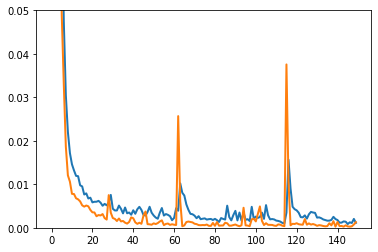

In [41]:
plot_history([train_loss_history, eval_loss_history], [0,0.05])

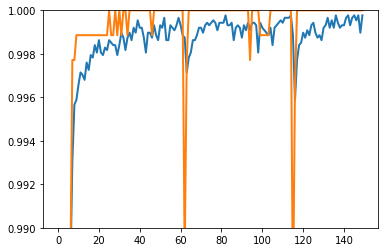

In [42]:
plot_history([train_acc_history, eval_acc_history], [0.99,1])

In [43]:
result = []
test(model, result, test_dataloader)

Eval: [0/2920] Predict 1 
Eval: [1/2920] Predict 0 
Eval: [2/2920] Predict 1 
Eval: [3/2920] Predict 1 
Eval: [4/2920] Predict 1 
Eval: [5/2920] Predict 0 
Eval: [6/2920] Predict 0 
Eval: [7/2920] Predict 0 
Eval: [8/2920] Predict 1 
Eval: [9/2920] Predict 1 
Eval: [10/2920] Predict 1 
Eval: [11/2920] Predict 1 
Eval: [12/2920] Predict 1 
Eval: [13/2920] Predict 1 
Eval: [14/2920] Predict 0 
Eval: [15/2920] Predict 0 
Eval: [16/2920] Predict 0 
Eval: [17/2920] Predict 0 
Eval: [18/2920] Predict 1 
Eval: [19/2920] Predict 1 
Eval: [20/2920] Predict 1 
Eval: [21/2920] Predict 0 
Eval: [22/2920] Predict 0 
Eval: [23/2920] Predict 0 
Eval: [24/2920] Predict 0 
Eval: [25/2920] Predict 1 
Eval: [26/2920] Predict 1 
Eval: [27/2920] Predict 0 
Eval: [28/2920] Predict 0 
Eval: [29/2920] Predict 1 
Eval: [30/2920] Predict 0 
Eval: [31/2920] Predict 0 
Eval: [32/2920] Predict 1 
Eval: [33/2920] Predict 1 
Eval: [34/2920] Predict 1 
Eval: [35/2920] Predict 1 
Eval: [36/2920] Predict 0 
Eval: [37/2

In [44]:
# print(result)

In [45]:
## Joanna Yao - random forest 
# train_data, eval_data, train_label, eval_label 
# imports
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# build the model
rf_model = RandomForestClassifier(n_estimators=50, max_depth = 10)
# train the model
rf_model.fit(train_data,train_label)
# feature selection
import pandas as pd
train_rf = pd.DataFrame(train_rf)
feature_imp = pd.Series(rf_model.feature_importances_).sort_values(ascending=False)
feature_imp
# make prediction
y_pred=rf_model.predict(eval_data)
# calculate accuracy
#print("Accuracy:",metrics.accuracy_score(eval_label, y_pred))

In [46]:
train_data_selected = train_data[:, [6, 2, 12, 10, 9, 8, 1 ]]
rf_model.fit(train_data_selected,train_label)
eval_data_selected = eval_data[:, [6, 2, 12, 10, 9, 8, 1 ]]
# make prediction
y_pred=rf_model.predict(eval_data_selected)
# calculate accuracy
random_forest_accuracy = metrics.accuracy_score(eval_label, y_pred)
print("Accuracy:", random_forest_accuracy)

Accuracy: 0.9988584474885844


In [47]:
# Kelly Wang : knn
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(train_data, train_label)
knn_y_pred = knn_model.predict(eval_data)
knn_accuracy = metrics.accuracy_score(eval_label, knn_y_pred)
print("Accuracy:", knn_accuracy)

Accuracy: 0.980593607305936


In [48]:
test_data_selected = test_data[:, [6, 2, 12, 10, 9, 8, 1 ]]
rf_predictions = rf_model.predict(test_data_selected)

In [49]:
df_test = pd.read_csv('edx_test.csv')

# Save your predictions as a CSV
to_save = df_test[['userid_DI']].copy()
to_save.loc[:, 'certified'] = rf_predictions
to_save.to_csv('submission.csv', index=False)

In [50]:
import matplotlib.pyplot as plt

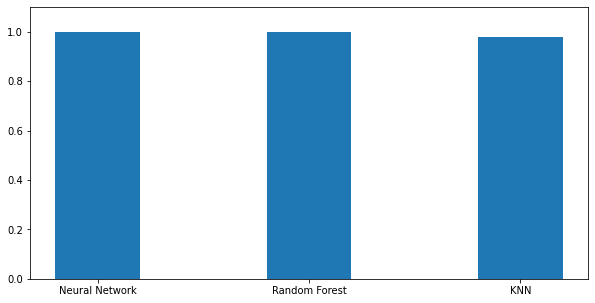

In [51]:
data = {'Neural Network': eval_acc_history[-1],'Random Forest':random_forest_accuracy, 'KNN': knn_accuracy}
model_names = list(data.keys())
accuracy = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
_ = plt.bar(model_names, accuracy,
        width = 0.4)
_ = plt.ylim(0, 1.1)

This bar chart shows the accuracies for all three of our models. Neural Network and Random Forest have relatively higher model performance than KNN. However, their accuracies are all higher than 0.98. 


For Random Forest, we performed feature selection by using the `rf_model.feature_importances_` function. As a result, we found that features [6, 2, 12, 10, 9, 8, 1] seemed more important for our final model. These features correspond to variables `final_cc_cname_DI`, `registered`, `last_event_DI`, `grade`, `gender`, `YoB`, and `userid_DI` in our dataset.

Considering and discuss the ethical implications of using the model we have trained. If we were hired to work as a data scientist for an online education platform. They want to use our model to predict which students they should tailor their course material towards so they can maximize their profits. Their idea is to use the model to help predict which student groups would make them the most money by getting the most participants to complete their paid certificate program. 

An ethical consideration we should think about before acting on this plan is the potential gender bias in the model. We noticed that the `gender` and `final_cc_cname_DI` variables are included as important features in the model. If the model uses these information as features, it is possible to lead to gender bias or reinforce bias towards students from specific countries.